In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x
import pandas as pd
import time
from imrdmd import DynamicModeDecomposition
import util

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

## Read Data

In [2]:
with open('data.npy', 'rb') as f:
    data = np.load(f)

## Incremental mrDMD

In [4]:
# ensure the step parameter is appropriate, too large may lead to higher accumulated errors. 
# Read about Hankel Matrix approximation to handle longer steps values -> https://epubs.siam.org/doi/book/10.1137/1.9781611974508
max_levels=10
splt = util.get_splt(1000, max_levels)

step = 1000
data1 = data[:,:step]
ddd = DynamicModeDecomposition(data1, max_levels)
data1.shape

(1000, 1000)

In [5]:
st = time.time()
nodes = ddd.mrdmd(data1,max_levels=max_levels, split_points=splt)
time.time()-st, len(nodes)

(2.8120670318603516, 102)

In [6]:
splt = util.get_splt(1000, max_levels)
data2 = data[:, 2000:3000]
st = time.time()
nodes_inc = ddd.inc_mrdmd(data2, max_levels=max_levels+1, offset=0, split_points=splt)
(time.time()-st), len(nodes_inc)

(0.8404016494750977, 205)

In [7]:
nodes = nodes_inc
leveln = [n for n in nodes if n.level==0]

## Data Reconstruction

In [8]:
num_nodes = max([nn.level for nn in nodes])
D_mrdmd = [dot(*ddd.stitch(nodes, i)) for i in range(num_nodes+1)]

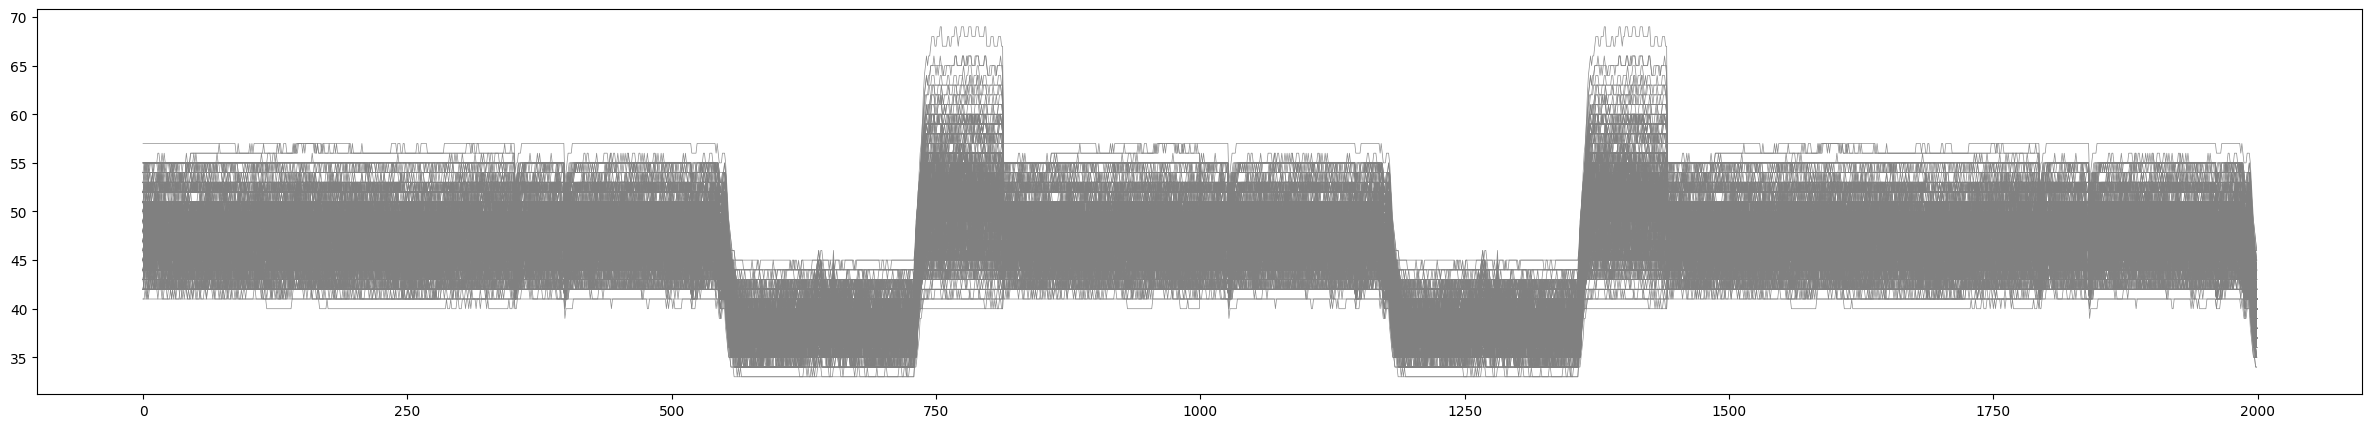

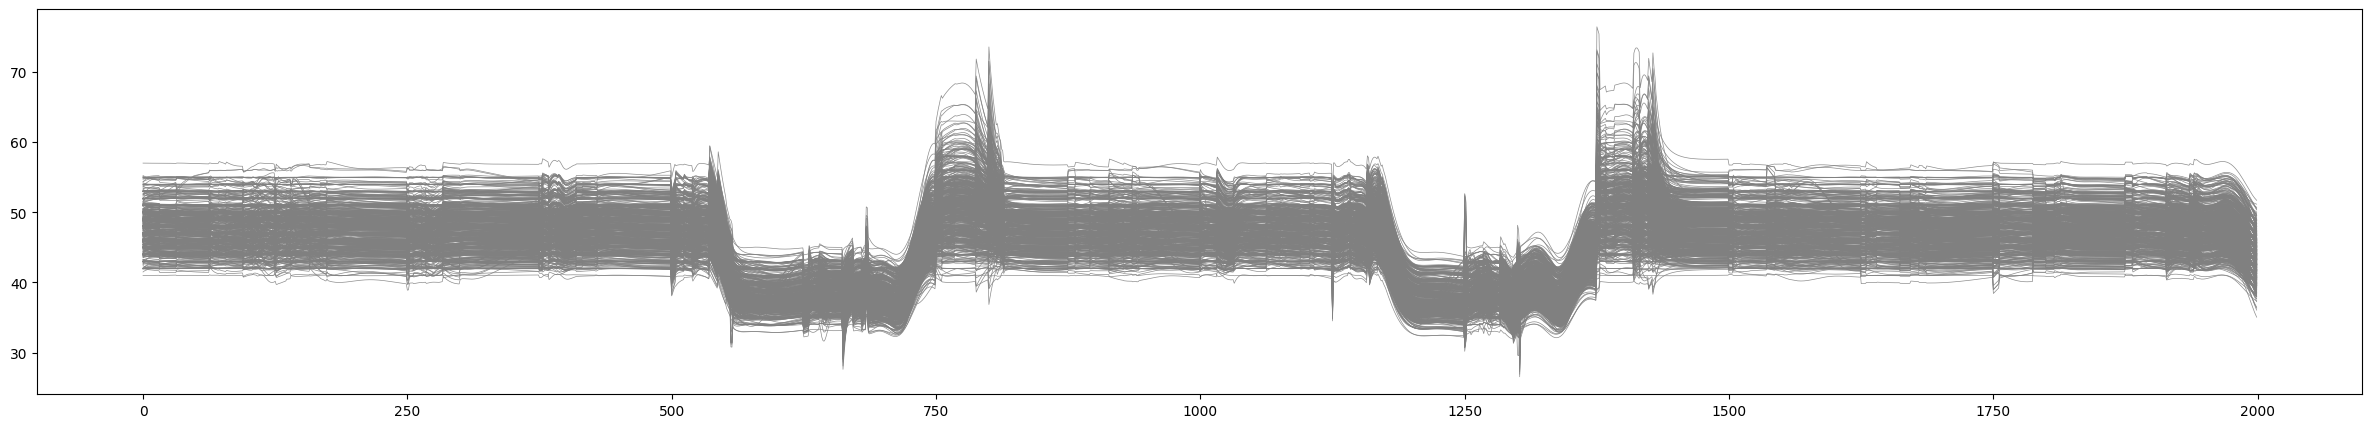

In [9]:
#display actual and reconstructed data 
#number of levels, split ranges, sampling rate contribute to quality of reconstruction
df_recon = pd.DataFrame(leveln[0].D.real.T)
df_recon.plot(figsize=(30,5),color='gray', alpha=0.9, lw=0.5, legend=False)
plt.show()

df_recon = pd.DataFrame(sum(D_mrdmd).real.T)
df_recon.plot(figsize=(30,5),color='gray', alpha=0.9, lw=0.5, legend=False)
plt.show()

## Plot i-mrDMD modes 

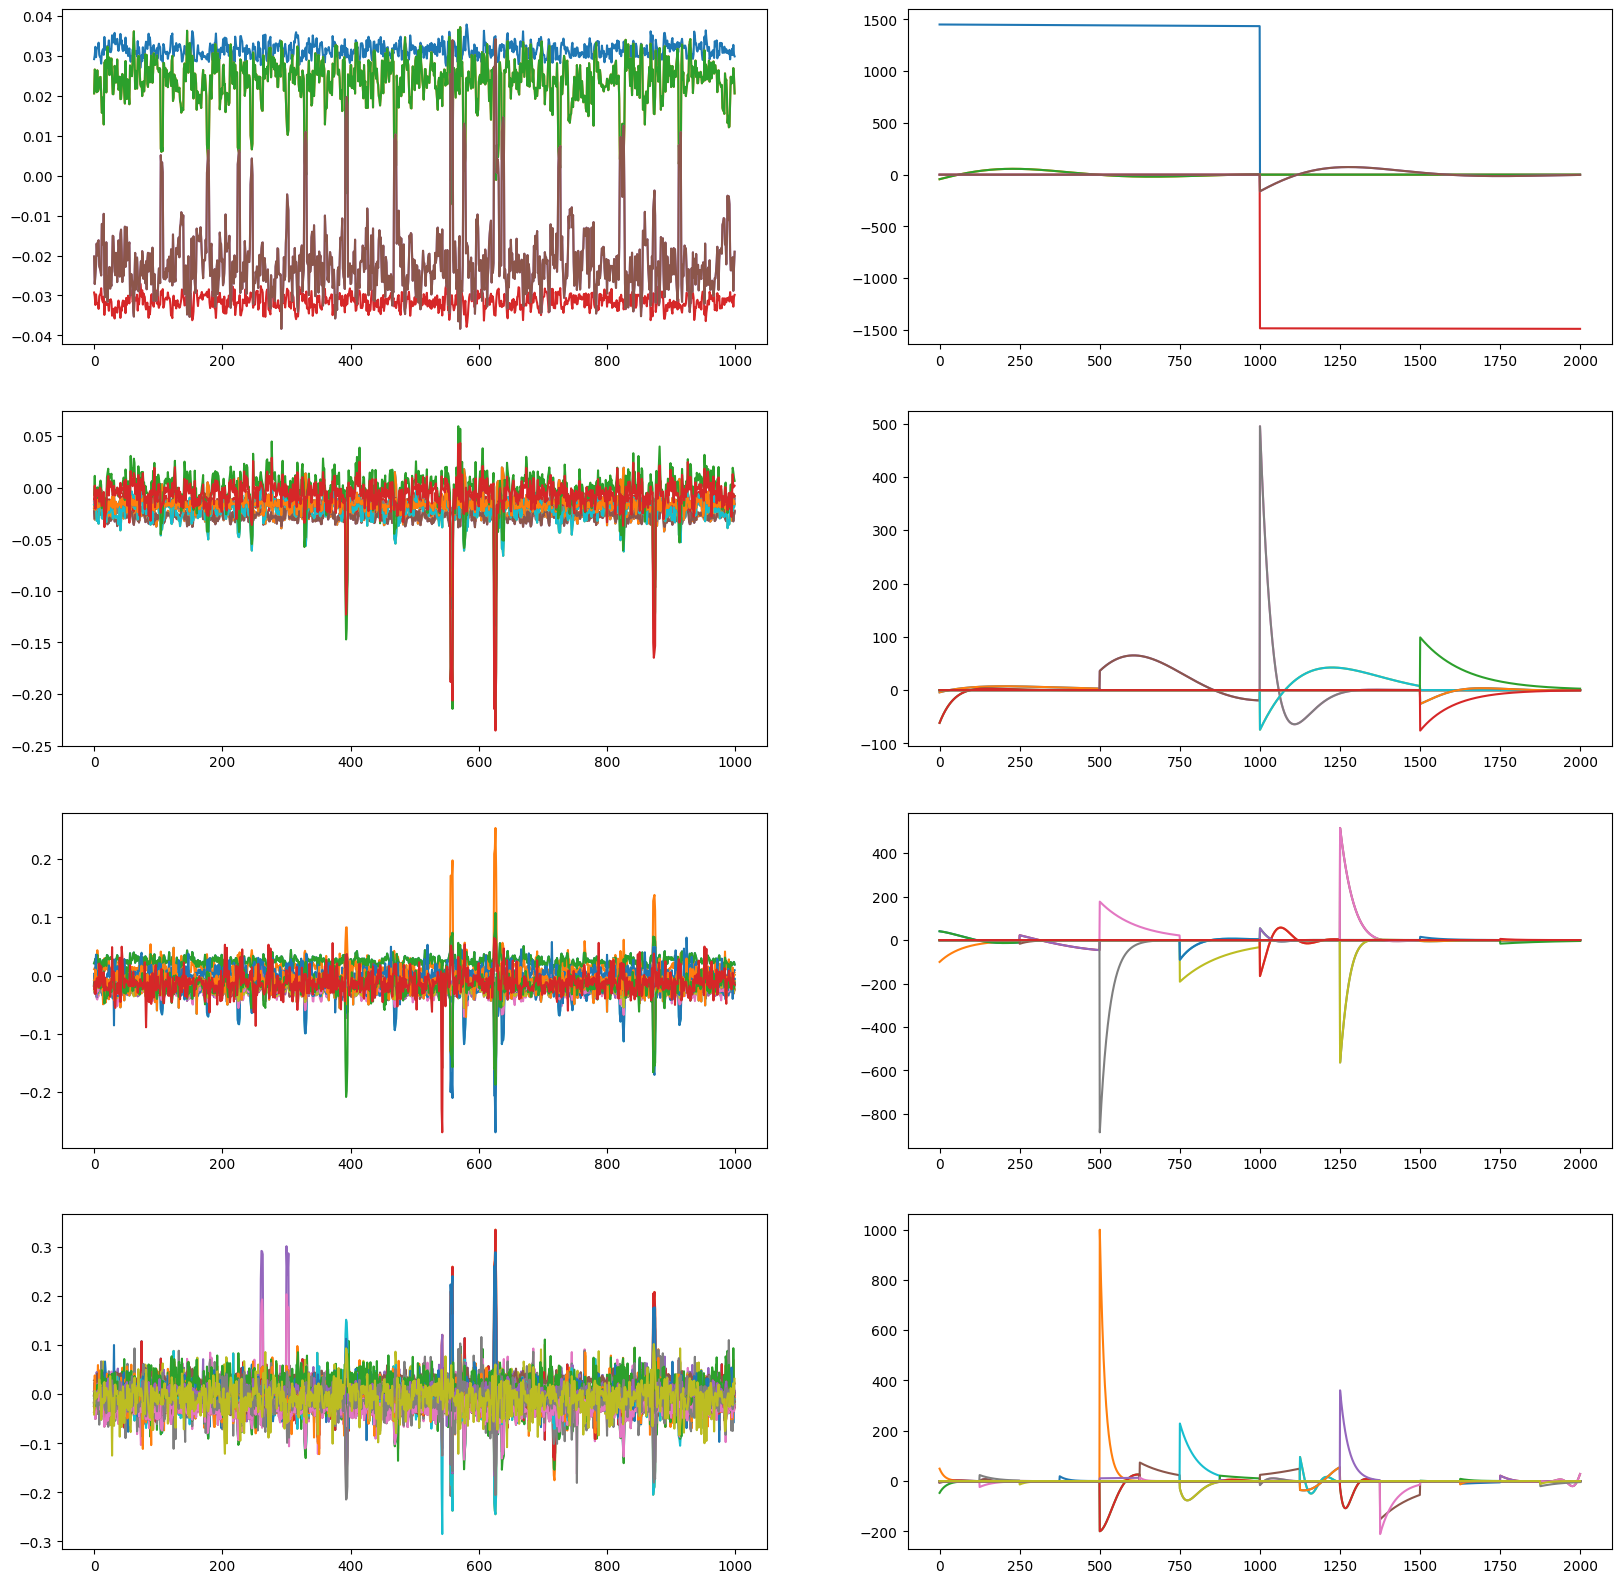

In [11]:
#refer https://humaticlabs.com/blog/mrdmd-python/
phs = []
for i in range(5):
    Phi_,Psi_ = ddd.stitch(nodes, i)
    if len(sum(Phi_))!=0:
        phs.append([Phi_,Psi_])
    
fig, axs = plt.subplots(len(phs),2, figsize=(20,20))

for ii, ax in enumerate(axs):
    ax[0].plot(phs[ii][0].real)
    ax[1].plot(phs[ii][1].real.T)
plt.show()

## Zscore Analysis

In [13]:
baselines = []
baseline_indx = []
for i in range(data.shape[0]):
    t = data[i, :]
    if min(t) >=44 and max(t) < 60:
        baselines.append(t)
        baseline_indx.append(i)
        c = "red" if i > 500 else "black"
        
n_baseline_indx = [nb for nb in range(data.shape[0]) if nb not in baseline_indx]

In [14]:
# standard deviation of modes using only baselines readings
# For std_baselines run cell below with `std_curr = std_baselines` commented out
std_baselines = 0.0032

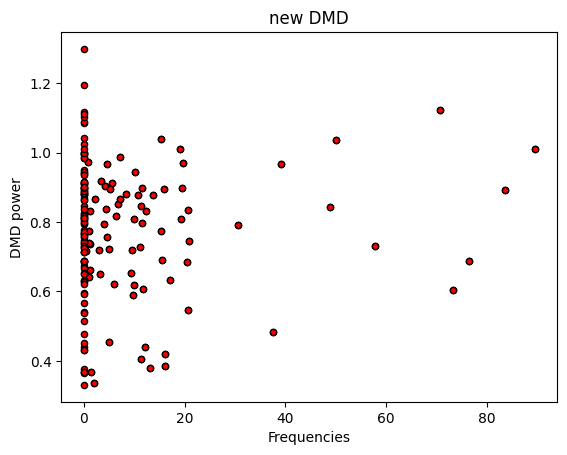

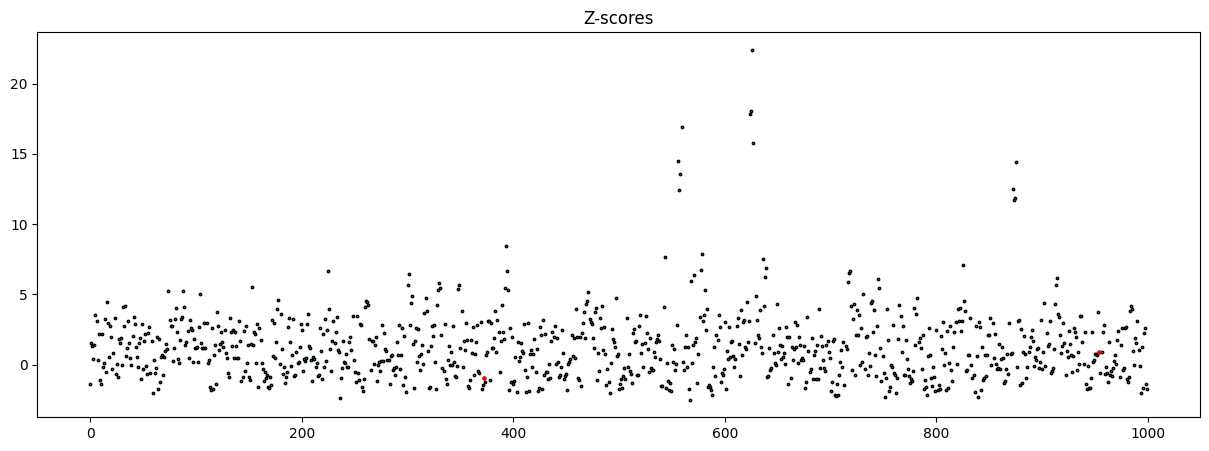

In [15]:
#showing zscore computation only for data1 
# For more details refer https://doi.org/10.1016/j.jneumeth.2015.10.010
zscore_list = []

D__ = data1.copy()

meas_count = data1.shape[0]

ax = plt.subplot()
std_currs = []
tsIDs = []

brkPoints_levels = [[(0,data1.shape[1])]]
for splits in splt:
    split = [0] + splits + [data1.shape[1]]
    brkPoints_levels.append(list(zip(split[:-1], split[1:])))
    
# Here we choose to compute the zscores for the entire timeline - range 1
for blev in range(1):
    for tsID in brkPoints_levels[blev]:
        level = len(brkPoints_levels)

        t = np.arange(0,np.diff(tsID)[0],1)
        
        sorted_nodes = [n for l in range(level) 
                for n in util.get_sorted_nodes_in_level(nodes,l)[0] if n.start <= tsID[1] and 
                n.stop >= tsID[0]]

        mu = np.hstack([n.mu for n in sorted_nodes])

        dt = None
        if len(t) == 1:
            dt = 1
        else:
            dt = 1/len(t)

        omega = np.hstack([np.log(n.mu)*100/(n.step) for n in sorted_nodes])
        phi = np.hstack([n.Phi for n in sorted_nodes])

        f = abs(omega.imag/2*np.pi)
        P = diag(np.matmul(phi.conj().T, phi))

        #mrdmd power spectrum
        plt.scatter(x=f, y=P.real, c='red',edgecolor='black', s=20 ,label= "Not Baseline" )

        plt.xlabel('Frequencies')
        plt.ylabel('DMD power')
        plt.title("new DMD")

        Xaug_small = D__[:, tsID[0]:tsID[1]]

        indxs = []

        #choose the appropriate frequency range 
        for ind, (fr, ph) in enumerate(zip(f, P)):
            if fr > 0 and fr < 60:
                indxs.append(ind)
        if len(indxs) == 0:
            continue
            indxs = [i for i in range(len(P))]

        tsIDs.append(tsID)
   
        dmd_mode_freqs = phi[:,indxs]
        dmd_freqs_mean = np.mean(abs(dmd_mode_freqs), axis=1)
        dmd_freqs_mean = dmd_freqs_mean[:meas_count]
        
        # subtract baseline mode with the current readings (curr) 
        baseline_mean = np.mean(dmd_freqs_mean[baseline_indx])
        n_baseline_dmd_modes = dmd_freqs_mean[n_baseline_indx] - baseline_mean
        val = [np.power(dmd_freqs_mean[i]-baseline_mean, 2) for i in n_baseline_indx]
        std_curr = np.sqrt(np.mean(val))
        std_currs.append(std_curr)
        std_curr = std_baselines

        #zscore
        dmd_mode_n_baseline = dmd_freqs_mean#[n_baseline_indx]
        zscore_1 = (dmd_mode_n_baseline - baseline_mean)/std_curr
        zscore_list.append(zscore_1)

    plt.show()
    plt.figure(figsize= (15,5))
    for zscore_1 in zscore_list: 

        ax = plt.scatter( x = np.arange(len(zscore_1)), y = zscore_1, s=3, edgecolors='black')
        plt.scatter(x = baseline_indx, y = zscore_1[baseline_indx], c='red',s=5,edgecolors='red')
    plt.title("Z-scores")
    plt.show()

